In [5]:
!pip install opencv-python

In [353]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tabulate import tabulate
from skimage.morphology import disk
from skimage.filters.rank import enhance_contrast
from skimage.feature import peak_local_max
import glob
%matplotlib inline

In [354]:
#images list
dir_folder = Path("F:\data\data")
imgs = list(dir_folder.glob("im*.jpg"))
images_list = []
for img in imgs:
    images_list.append(cv2.imread(str(img)))

In [355]:
#gold cells list
cells = list(dir_folder.glob("im*_gold_cells.txt"))
cells_list= []
for cell in cells:
    cells_list.append(np.loadtxt(str(cell)))

In [356]:
#mask list
masks = list(dir_folder.glob("im*_gold_mask.txt"))
masks_list = []
for mask in masks:
    masks_list.append(np.loadtxt(str(mask)))

In [357]:
def image_process(im):
    gray_image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(enhance_contrast(gray_image, disk(3)), (3, 3), 0)
    return blurred

PART 1

In [358]:
def ObtainForegroundMask(im):
    blurred = image_process(im)
    _, mask = cv2.threshold(blurred, 0,1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    mask = 1 - mask
    kernel = np.ones((32, 32), np.uint8)
    result = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return result

In [359]:
obtainforegrounds = []
for img in images_list:
    obtainforegrounds.append(ObtainForegroundMask(img))

In [360]:
def evaluation(predicted, truth):
  TP = np.sum(np.logical_and(predicted,truth))
  FP = np.sum(np.logical_and(predicted,1 - truth))
  FN = np.sum(np.logical_and(1 - predicted,truth))

  precision = TP / (TP + FP+ 1e-6)
  recall = TP / (TP + FN + 1e-6)
  f_score = 2*(precision*recall)/(precision+recall)
  return precision, recall, f_score

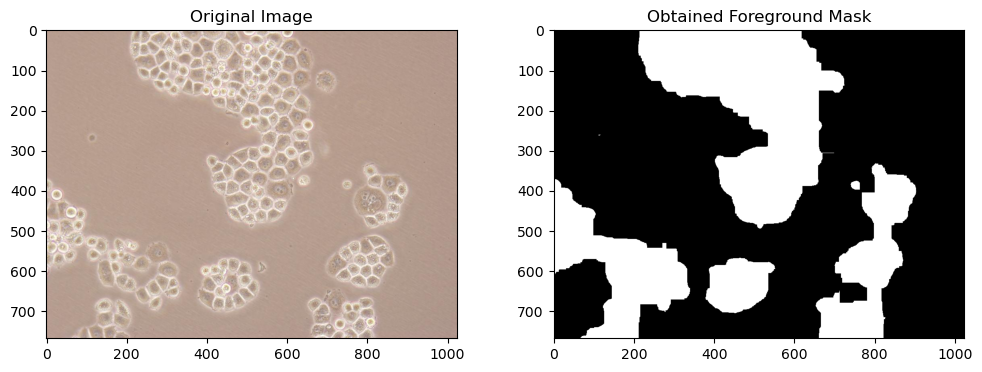

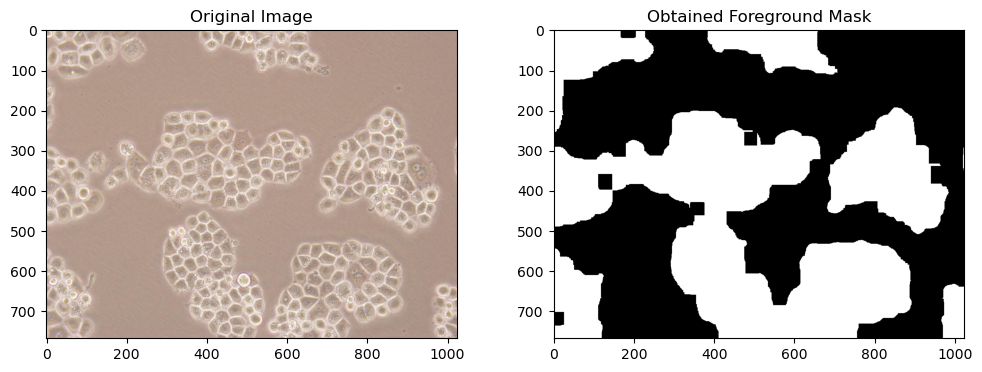

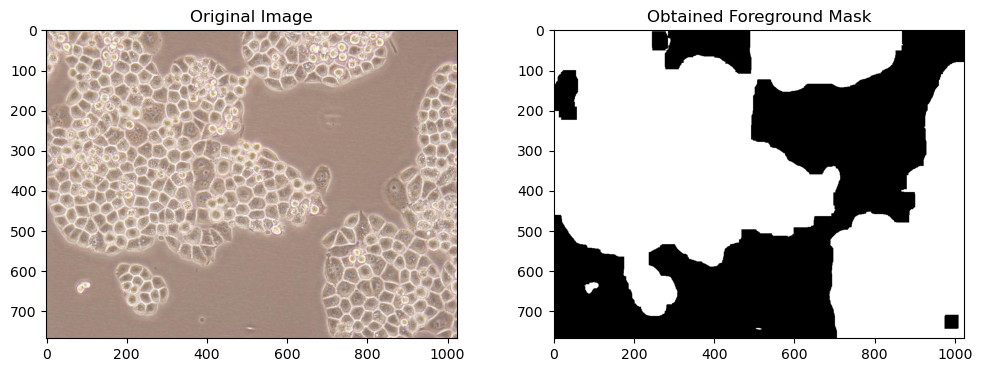

In [361]:
for i in range(len(images_list)):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(cv2.cvtColor(images_list[i], cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    
    axes[1].imshow(obtainforegrounds[i], cmap='gray')
    axes[1].set_title('Obtained Foreground Mask')
    
    plt.show()

In [362]:
results = []
for i in range(len(obtainforegrounds)):
    p, r, f = evaluation(obtainforegrounds[i], masks_list[i])
    results.append([i+1, f"{p:.2f}", f"{r:.2f}", f"{f:.2f}"])

headers = ["Image No", "Precision", "Recall", "F-score"]

print(tabulate(results, headers=headers, tablefmt="grid"))

+------------+-------------+----------+-----------+
|   Image No |   Precision |   Recall |   F-score |
+============+=============+==========+===========+
|          1 |        0.91 |     0.99 |      0.95 |
+------------+-------------+----------+-----------+
|          2 |        0.94 |     0.98 |      0.96 |
+------------+-------------+----------+-----------+
|          3 |        0.97 |     0.98 |      0.98 |
+------------+-------------+----------+-----------+


PART 2

In [363]:
def findCellLocations(img, obtainForeground):
    blurred = image_process(img)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)  # Create a kernel of ones
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    mask = 255 - mask
    
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 0)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    
    peaks = peak_local_max(dist, min_distance=10)

    centers = peaks[obtainForeground[peaks[:, 0], peaks[:, 1]] == 255]
    
    return centers

In [364]:
locations = []
for i in range(len(images_list)):
    locations.append(findCellLocations(images_list[i], obtainforegrounds[i]*255))

In [365]:
def evaluation2(predicted, truth):
    TP, FP = 0,0
    checked = set()

    for location in predicted:
        loc1, loc2 = location
        if truth[loc1, loc2] != 0:
            if truth[loc1, loc2] not in checked:
                TP += 1
                checked.add(truth[loc1, loc2])

    FP = len(predicted) - TP

    unique_cells = set(truth[truth != 0])
    FN = len(unique_cells) - len(checked)

    precision = TP / (TP + FP+ 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f_score = 2*(precision*recall)/(precision+recall)

    return precision, recall, f_score

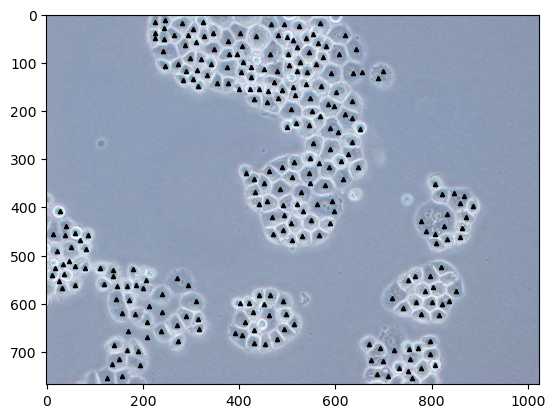

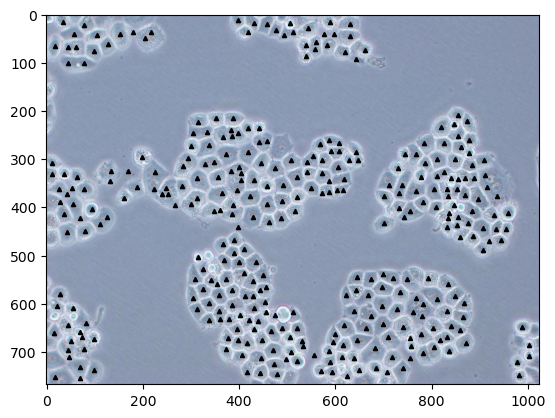

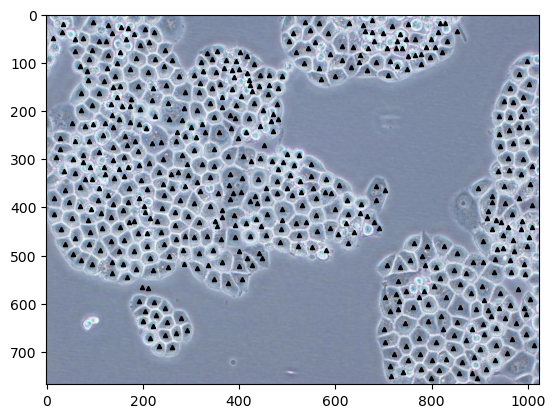

In [366]:
for i in range(len(images_list)):
    plt.plot(locations[i][:, 1], locations[i][:, 0], "k^", markersize=3)
    plt.imshow(images_list[i])
    plt.show()

In [367]:
results2 = []
for i in range(len(obtainforegrounds)):
    p, r, f = evaluation2(locations[i], cells_list[i])
    results2.append([i+1, f"{p:.2f}", f"{r:.2f}", f"{f:.2f}"])

headers = ["Image No", "Precision", "Recall", "F-score"]

print(tabulate(results2, headers=headers, tablefmt="grid"))

+------------+-------------+----------+-----------+
|   Image No |   Precision |   Recall |   F-score |
+============+=============+==========+===========+
|          1 |        0.83 |     0.91 |      0.87 |
+------------+-------------+----------+-----------+
|          2 |        0.82 |     0.92 |      0.87 |
+------------+-------------+----------+-----------+
|          3 |        0.8  |     0.89 |      0.85 |
+------------+-------------+----------+-----------+


PART 3

In [368]:
def FindCellBoundaries(image, foreground_map, cell_locations):
    labels = np.zeros_like(foreground_map, dtype=int)
    label_count = 1 

    for loc in cell_locations:
        if labels[loc[0], loc[1]] == 0:
            queue = [loc]
            labels[loc[0], loc[1]] = label_count
            while queue:
                x, y = queue.pop(0)
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1]:
                            if labels[nx, ny] == 0 and foreground_map[nx, ny] == 1:
                                if np.linalg.norm(image[nx, ny] - image[x, y]) < 30:
                                    queue.append((nx, ny))
                                    labels[nx, ny] = label_count
            label_count += 1

    return labels

In [369]:
segmented_maps = []
for i in range(len(images_list)):
    segmented_maps.append(FindCellBoundaries(images[i], obtainforegrounds[i], locations[i]))


In [370]:
def evaluation3(segmentation, ground_truth):
    dice_scores = []
    iou_scores = []

    seg_labels = np.unique(segmentation)
    gt_labels = np.unique(ground_truth)

    seg_labels = seg_labels[seg_labels != 0]
    gt_labels = gt_labels[gt_labels != 0]

    for gt_label in gt_labels:
        gt_mask = ground_truth == gt_label
        overlaps = [np.sum(gt_mask & (segmentation == seg_label)) for seg_label in seg_labels]
        
        if overlaps:
            best_match = seg_labels[np.argmax(overlaps)]
            seg_mask = segmentation == best_match

            intersection = np.sum(gt_mask & seg_mask)
            union = np.sum(gt_mask | seg_mask)
            dice_score = 2 * intersection / (np.sum(gt_mask) + np.sum(seg_mask))
            iou_score = intersection / union

            dice_scores.append(dice_score)
            iou_scores.append(iou_score)

    return dice_scores, iou_scores

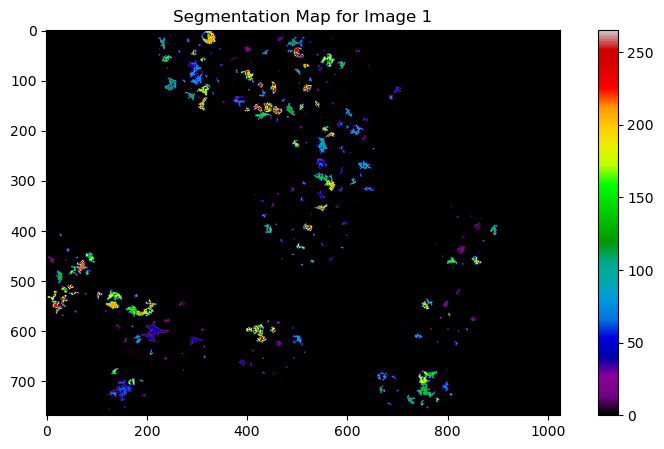

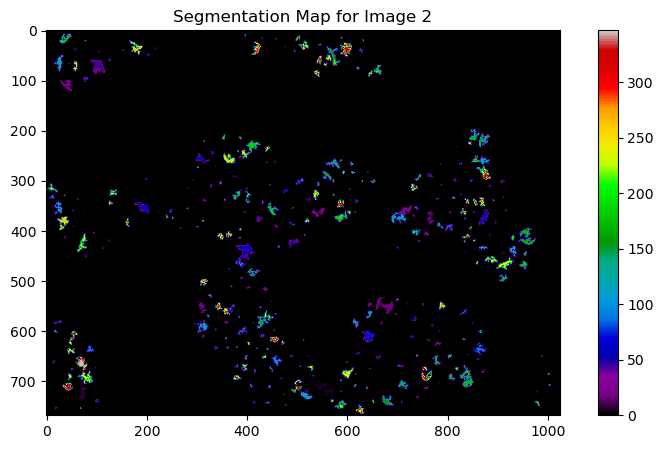

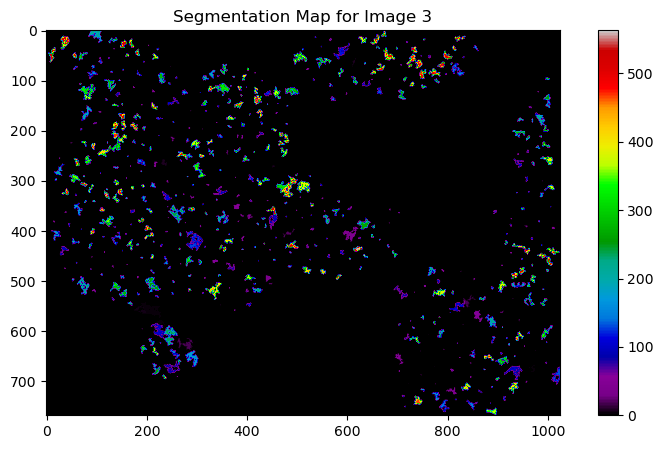

In [371]:
for i, segmented_map in enumerate(segmented_maps):
    plt.figure(figsize=(10, 5))
    plt.imshow(segmented_map, cmap='nipy_spectral')
    plt.colorbar()
    plt.title(f"Segmentation Map for Image {i+1}")
    plt.show()

In [372]:
results3 = []

for i in range(len(images_list)):
    dice_scores, iou_scores = evaluation3(segmented_maps[i], masks_list[i])

    for j in range(len(dice_scores)):
        results3.append([f"Image {i+1}", f"{dice_scores[j]:.4f}", f"{iou_scores[j]:.4f}"])

headers = ["Image", "Dice Score", "IoU Score"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+----+---------+--------------+-------------+
|    |   Image |   Dice Score |   IoU Score |
+====+=========+==============+=============+
|  1 |    0.91 |         0.99 |        0.95 |
+----+---------+--------------+-------------+
|  2 |    0.94 |         0.98 |        0.96 |
+----+---------+--------------+-------------+
|  3 |    0.97 |         0.98 |        0.98 |
+----+---------+--------------+-------------+


PART 4

In [373]:
def moreEnhancedImage(image):
    blurred = image_process(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
    enhanced_image = clahe.apply(blurred)
    return enhanced_image

In [374]:
def vesselsMask(image_path):
    processed_image = moreEnhancedImage(image)
    binary_vessel_mask = cv2.adaptiveThreshold(processed_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 11)
    binary_vessel_mask = 255 - binary_vessel_mask
    kernel = np.ones((3,3), np.uint8)
    vessel_mask = cv2.morphologyEx(binary_vessel_mask, cv2.MORPH_CLOSE, kernel)

    return vessel_mask

In [375]:
def evaluation4(predicted, truth):
  TP = np.sum(np.logical_and(predicted,truth))
  FP = np.sum(np.logical_and(predicted,1 - truth))
  FN = np.sum(np.logical_and(1 - predicted,truth))

  precision = TP / (TP + FP+ 1e-6)
  recall = TP / (TP + FN + 1e-6)
  f_score = 2*(precision*recall)/(precision+recall)
  return precision, recall, f_score

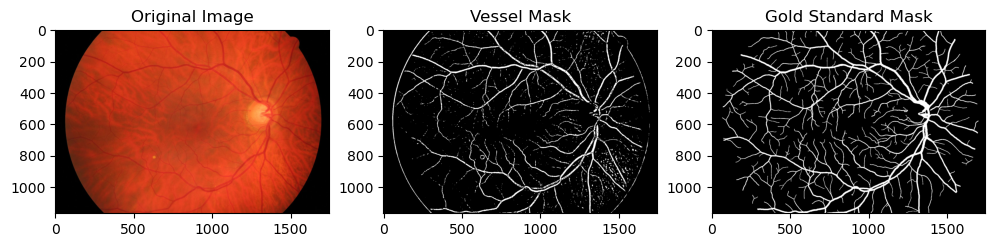

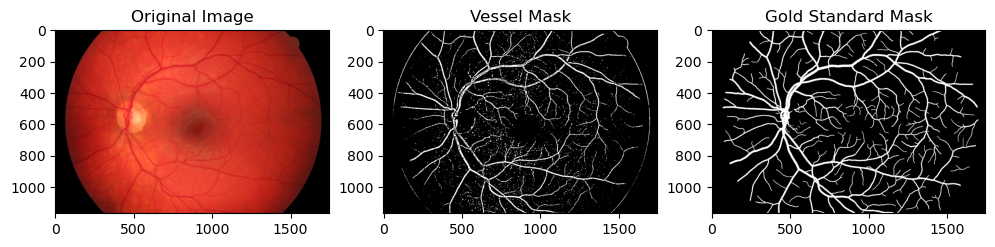

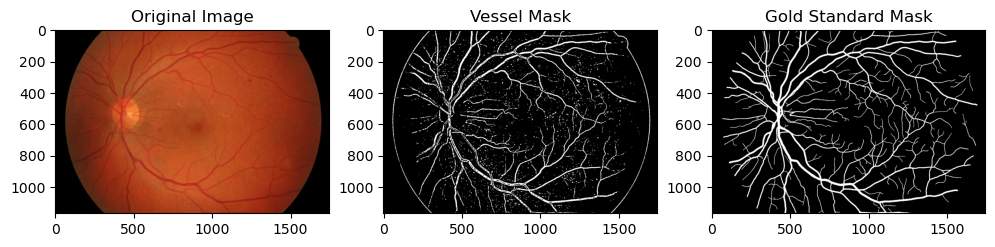

In [376]:
dir_folder = Path("F:/fundus/fundus")
fimgs = list(dir_folder.glob("*.jpg"))
gimgs = list(dir_folder.glob("*.png"))
predicted_mask_list = []
gold_mask_list = []

for i in range(len(fimgs)):
    # Read image and gold standard mask
    image_path = str(fimgs[i])
    gold_mask_path = str(gimgs[i])

    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gold_mask = cv2.imread(gold_mask_path, cv2.IMREAD_GRAYSCALE)
    gold_mask_list.append(gold_mask)

    predicted_mask = vesselsMask(image)
    predicted_mask_list.append(predicted_mask)
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Vessel Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(gold_mask, cmap='gray')
    plt.title('Gold Standard Mask')

    plt.show()

In [377]:
results4 = []
for i in range(len(predicted_mask_list)):
    p, r, f = evaluation4(predicted_mask_list[i], gold_mask_list[i])
    results4.append([i+1, f"{p:.2f}", f"{r:.2f}", f"{f:.2f}"])

headers = ["Image No", "Precision", "Recall", "F-score"]
print(tabulate(results4, headers=headers, tablefmt="grid"))

+------------+-------------+----------+-----------+
|   Image No |   Precision |   Recall |   F-score |
+============+=============+==========+===========+
|          1 |        0.8  |     0.35 |      0.49 |
+------------+-------------+----------+-----------+
|          2 |        0.81 |     0.35 |      0.49 |
+------------+-------------+----------+-----------+
|          3 |        0.71 |     0.37 |      0.48 |
+------------+-------------+----------+-----------+
